# Quasi-harmonic Workflow Tutorial with VASP

This first part is only needed as we have to mock VASP here as we cannot run it directly in a jupyter notebook:

In [1]:
import warnings

from mock_vasp import TEST_DIR, mock_vasp

ref_paths = {
    "phonon static 1/1": "Si_qha_2/phonon_static_1_1",
    "static": "Si_qha_2/static",
    "tight relax 1 EOS equilibrium relaxation": "Si_qha_2/tight_relax_1",
    "tight relax 2 EOS equilibrium relaxation": "Si_qha_2/tight_relax_2",
    "tight relax 1 deformation 0": "Si_qha_2/tight_relax_1_d0",
    "tight relax 1 deformation 1": "Si_qha_2/tight_relax_1_d1",
    "tight relax 1 deformation 2": "Si_qha_2/tight_relax_1_d2",
    "tight relax 1 deformation 3": "Si_qha_2/tight_relax_1_d3",
    "tight relax 1 deformation 4": "Si_qha_2/tight_relax_1_d4",
    "tight relax 1 deformation 5": "Si_qha_2/tight_relax_1_d5",
    "tight relax 2 deformation 0": "Si_qha_2/tight_relax_2_d0",
    "tight relax 2 deformation 1": "Si_qha_2/tight_relax_2_d1",
    "tight relax 2 deformation 2": "Si_qha_2/tight_relax_2_d2",
    "tight relax 2 deformation 3": "Si_qha_2/tight_relax_2_d3",
    "tight relax 2 deformation 4": "Si_qha_2/tight_relax_2_d4",
    "tight relax 2 deformation 5": "Si_qha_2/tight_relax_2_d5",
    "dft phonon static eos deformation 1": "Si_qha_2/"
    "dft_phonon_static_eos_deformation_1",
    "dft phonon static eos deformation 2": "Si_qha_2/"
    "dft_phonon_static_eos_deformation_2",
    "dft phonon static eos deformation 3": "Si_qha_2/"
    "dft_phonon_static_eos_deformation_3",
    "dft phonon static eos deformation 4": "Si_qha_2/"
    "dft_phonon_static_eos_deformation_4",
    "dft phonon static eos deformation 5": "Si_qha_2/"
    "dft_phonon_static_eos_deformation_5",
    "dft phonon static eos deformation 6": "Si_qha_2/"
    "dft_phonon_static_eos_deformation_6",
    "dft phonon static eos deformation 7": "Si_qha_2/"
    "dft_phonon_static_eos_deformation_7",
    "dft phonon static 1/1 eos deformation 1": "Si_qha_2/"
    "dft_phonon_static_1_1_eos_deformation_1",
    "dft phonon static 1/1 eos deformation 2": "Si_qha_2/"
    "dft_phonon_static_1_1_eos_deformation_2",
    "dft phonon static 1/1 eos deformation 3": "Si_qha_2/"
    "dft_phonon_static_1_1_eos_deformation_3",
    "dft phonon static 1/1 eos deformation 4": "Si_qha_2/"
    "dft_phonon_static_1_1_eos_deformation_4",
    "dft phonon static 1/1 eos deformation 5": "Si_qha_2/"
    "dft_phonon_static_1_1_eos_deformation_5",
    "dft phonon static 1/1 eos deformation 6": "Si_qha_2/"
    "dft_phonon_static_1_1_eos_deformation_6",
    "dft phonon static 1/1 eos deformation 7": "Si_qha_2/"
    "dft_phonon_static_1_1_eos_deformation_7",
}

/home/jgeorge/miniconda3/envs/Fix_Gruneisentutorial/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This tutorial will make use of a quasi-harmonic workflow that allows to include volume-dependent anharmonicity into the calculation of phonon free energies.
Please check out the paper by Togo to learn about the exact implementation as we will rely on Phonopy to perform the quasi-harmonic approximation: https://doi.org/10.7566/JPSJ.92.012001.
At the moment, we perform harmonic free energy calculation along a volume curve to arrive at free energy-volume curves that are the starting point for the quasi-harmonic approximation.

## Let's run the workflow
Now, we load a structure and other important functions and classes for running the qha workflow.

In [2]:
from jobflow import JobStore, run_locally
from maggma.stores import MemoryStore
from pymatgen.core import Structure

from atomate2.vasp.flows.qha import QhaMaker

job_store = JobStore(MemoryStore(), additional_stores={"data": MemoryStore()})
si_structure = Structure.from_file(TEST_DIR / "structures" / "Si_diamond.cif")

Then one can use the `QhaMaker` to generate a `Flow`.
First, the structure will be optimized than the structures will be optimized at constant volume along an energy volume curve. 
Please make sure the structural optimizations are tight enough. At each of these volumes, a phonon run will then be performed.
The quasi-harmonic approximation is only valid if the harmonic phonon curves don't show any imaginary modes. However, for testing, you
can also switch off this option.

Before we start the quasi-harmonic workflow, we adapt the first relaxation, the relaxation with different volumes and the static runs for the phonon calculation. As we deal with Si, we will not add the non-analytical term correction. For this we load the respective Makers.

In [3]:
from atomate2.vasp.flows.core import DoubleRelaxMaker
from atomate2.vasp.flows.phonons import PhononMaker
from atomate2.vasp.jobs.core import TightRelaxMaker
from atomate2.vasp.jobs.phonons import PhononDisplacementMaker
from atomate2.vasp.sets.core import StaticSetGenerator, TightRelaxSetGenerator

warnings.filterwarnings("ignore")

phonon_bulk_relax_maker_isif3 = DoubleRelaxMaker.from_relax_maker(
    TightRelaxMaker(
        run_vasp_kwargs={"handlers": ()},
        input_set_generator=TightRelaxSetGenerator(
            user_incar_settings={
                "GGA": "PE",
                "ISPIN": 1,
                "KSPACING": 0.1,
                "ALGO": "Normal",
                "LAECHG": False,
                "ISMEAR": 0,
                "ENCUT": 700,
                "IBRION": 1,
                "ISYM": 0,
                "SIGMA": 0.05,
                "LCHARG": False,
                "LWAVE": False,
                "LVTOT": False,
                "LORBIT": None,
                "LOPTICS": False,
                "LREAL": False,
                "ISIF": 3,
                "NPAR": 4,
            }
        ),
    )
)

phonon_bulk_relax_maker_isif4 = DoubleRelaxMaker.from_relax_maker(
    TightRelaxMaker(
        run_vasp_kwargs={"handlers": ()},
        input_set_generator=TightRelaxSetGenerator(
            user_incar_settings={
                "GGA": "PE",
                "ISPIN": 1,
                "KSPACING": 0.1,
                "ALGO": "Normal",
                "LAECHG": False,
                "ISMEAR": 0,
                "ENCUT": 700,
                "IBRION": 1,
                "ISYM": 0,
                "SIGMA": 0.05,
                "LCHARG": False,
                "LWAVE": False,
                "LVTOT": False,
                "LORBIT": None,
                "LOPTICS": False,
                "LREAL": False,
                "ISIF": 4,
                "NPAR": 4,
            }
        ),
    )
)


phonon_displacement_maker = PhononDisplacementMaker(
    run_vasp_kwargs={"handlers": ()},
    input_set_generator=StaticSetGenerator(
        user_incar_settings={
            "GGA": "PE",
            "IBRION": -1,
            "ISPIN": 1,
            "ISMEAR": 0,
            "ISIF": 3,
            "ENCUT": 700,
            "EDIFF": 1e-7,
            "LAECHG": False,
            "LREAL": False,
            "ALGO": "Normal",
            "NSW": 0,
            "LCHARG": False,
            "LWAVE": False,
            "LVTOT": False,
            "LORBIT": None,
            "LOPTICS": False,
            "SIGMA": 0.05,
            "ISYM": 0,
            "KSPACING": 0.1,
            "NPAR": 4,
        },
        auto_ispin=False,
    ),
)


phonon_displacement_maker.name = "dft phonon static"

Then we can construct a `QhaMaker` flow as follows:

In [4]:
flow = QhaMaker(
    initial_relax_maker=phonon_bulk_relax_maker_isif3,
    eos_relax_maker=phonon_bulk_relax_maker_isif4,
    min_length=10,
    phonon_maker=PhononMaker(
        generate_frequencies_eigenvectors_kwargs={
            "tmin": 0,
            "tmax": 1000,
            "tstep": 10,
        },
        bulk_relax_maker=None,
        born_maker=None,
        static_energy_maker=phonon_displacement_maker,
        phonon_displacement_maker=phonon_displacement_maker,
    ),
    linear_strain=(-0.15, 0.15),
    number_of_frames=6,
    pressure=None,
    t_max=None,
    ignore_imaginary_modes=False,
    skip_analysis=False,
    eos_type="vinet",
).make(structure=si_structure)

2025-03-16 12:57:42,696 INFO Started executing jobs locally
2025-03-16 12:57:42,710 INFO Starting job - tight relax 1 EOS equilibrium relaxation (b5edb3b4-99b5-4f35-9c21-a45f14985a00)


Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-03-16 12:57:43,822 INFO Finished job - tight relax 1 EOS equilibrium relaxation (b5edb3b4-99b5-4f35-9c21-a45f14985a00)
2025-03-16 12:57:43,823 WARNING Response.stored_data is not supported with local manager.
2025-03-16 12:57:43,824 INFO Starting job - tight relax 2 EOS equilibrium relaxation (3e2a665b-4b37-4e38-94df-93592722a724)


Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-03-16 12:57:45,259 INFO Finished job - tight relax 2 EOS equilibrium relaxation (3e2a665b-4b37-4e38-94df-93592722a724)
2025-03-16 12:57:45,260 WARNING Response.stored_data is not supported with local manager.
2025-03-16 12:57:45,261 INFO Starting job - apply_strain_to_structure (aeb2d80e-607e-4f39-92f9-52c2aa0eacc4)
2025-03-16 12:57:45,299 INFO Finished job - apply_strain_to_structure (aeb2d80e-607e-4f39-92f9-52c2aa0eacc4)
2025-03-16 12:57:45,299 INFO Starting job - tight relax 1 deformation 0 (852d87d5-42b5-41ca-8484-8a8ddfdde28e)


Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-03-16 12:57:46,494 INFO Finished job - tight relax 1 deformation 0 (852d87d5-42b5-41ca-8484-8a8ddfdde28e)
2025-03-16 12:57:46,494 WARNING Response.stored_data is not supported with local manager.
2025-03-16 12:57:46,495 INFO Starting job - tight relax 1 deformation 1 (4892e82a-8f8e-4ca6-a7a4-64760f97d698)


Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-03-16 12:57:47,488 INFO Finished job - tight relax 1 deformation 1 (4892e82a-8f8e-4ca6-a7a4-64760f97d698)
2025-03-16 12:57:47,489 WARNING Response.stored_data is not supported with local manager.
2025-03-16 12:57:47,490 INFO Starting job - tight relax 1 deformation 2 (ca461cc3-87ce-438d-8ebf-2f824d60e944)


Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-03-16 12:57:48,460 INFO Finished job - tight relax 1 deformation 2 (ca461cc3-87ce-438d-8ebf-2f824d60e944)
2025-03-16 12:57:48,461 WARNING Response.stored_data is not supported with local manager.
2025-03-16 12:57:48,462 INFO Starting job - tight relax 1 deformation 3 (3466816e-5fe4-4763-88e5-b7bb638a7cfb)


Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-03-16 12:57:49,429 INFO Finished job - tight relax 1 deformation 3 (3466816e-5fe4-4763-88e5-b7bb638a7cfb)
2025-03-16 12:57:49,431 WARNING Response.stored_data is not supported with local manager.
2025-03-16 12:57:49,432 INFO Starting job - tight relax 1 deformation 4 (db53f271-85d6-4728-8478-d58bbbb5f3e3)


Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-03-16 12:57:50,399 INFO Finished job - tight relax 1 deformation 4 (db53f271-85d6-4728-8478-d58bbbb5f3e3)
2025-03-16 12:57:50,400 WARNING Response.stored_data is not supported with local manager.
2025-03-16 12:57:50,400 INFO Starting job - tight relax 1 deformation 5 (b892cd12-bdc8-4a46-a937-c65e6ec73753)


Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-03-16 12:57:51,153 INFO Finished job - tight relax 1 deformation 5 (b892cd12-bdc8-4a46-a937-c65e6ec73753)
2025-03-16 12:57:51,153 WARNING Response.stored_data is not supported with local manager.
2025-03-16 12:57:51,154 INFO Starting job - tight relax 2 deformation 0 (2113efa2-df89-45d1-ad60-29b12fd9c3e9)


Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-03-16 12:57:52,414 INFO Finished job - tight relax 2 deformation 0 (2113efa2-df89-45d1-ad60-29b12fd9c3e9)
2025-03-16 12:57:52,415 WARNING Response.stored_data is not supported with local manager.
2025-03-16 12:57:52,415 INFO Starting job - tight relax 2 deformation 1 (fc5bcd4c-1cbb-49af-b94f-7361236b6dcb)


Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-03-16 12:57:53,353 INFO Finished job - tight relax 2 deformation 1 (fc5bcd4c-1cbb-49af-b94f-7361236b6dcb)
2025-03-16 12:57:53,354 WARNING Response.stored_data is not supported with local manager.
2025-03-16 12:57:53,355 INFO Starting job - tight relax 2 deformation 2 (dfe7fb1f-fade-4de4-98c3-889e4e426cb8)


Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-03-16 12:57:54,298 INFO Finished job - tight relax 2 deformation 2 (dfe7fb1f-fade-4de4-98c3-889e4e426cb8)
2025-03-16 12:57:54,299 WARNING Response.stored_data is not supported with local manager.
2025-03-16 12:57:54,299 INFO Starting job - tight relax 2 deformation 3 (2db3ce42-cd3e-4d28-8e65-c034d09474d7)


Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-03-16 12:57:55,272 INFO Finished job - tight relax 2 deformation 3 (2db3ce42-cd3e-4d28-8e65-c034d09474d7)
2025-03-16 12:57:55,273 WARNING Response.stored_data is not supported with local manager.
2025-03-16 12:57:55,273 INFO Starting job - tight relax 2 deformation 4 (0ad648bd-4fda-481c-8813-4f2b2084d03c)


Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-03-16 12:57:56,221 INFO Finished job - tight relax 2 deformation 4 (0ad648bd-4fda-481c-8813-4f2b2084d03c)
2025-03-16 12:57:56,221 WARNING Response.stored_data is not supported with local manager.
2025-03-16 12:57:56,222 INFO Starting job - tight relax 2 deformation 5 (ac1e4aee-ec96-43ec-8f6e-f79365bde4da)


Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-03-16 12:57:57,033 INFO Finished job - tight relax 2 deformation 5 (ac1e4aee-ec96-43ec-8f6e-f79365bde4da)
2025-03-16 12:57:57,036 WARNING Response.stored_data is not supported with local manager.
2025-03-16 12:57:57,037 INFO Starting job - get_supercell_size (be2a5067-b107-4cdf-b1d1-0717d1840e63)
2025-03-16 12:57:57,138 INFO Finished job - get_supercell_size (be2a5067-b107-4cdf-b1d1-0717d1840e63)
2025-03-16 12:57:57,139 INFO Starting job - get_phonon_jobs (8ffae517-b561-46f5-a5e7-8f04a9de9e92)
2025-03-16 12:57:58,066 INFO Finished job - get_phonon_jobs (8ffae517-b561-46f5-a5e7-8f04a9de9e92)
2025-03-16 12:57:58,105 INFO Starting job - dft phonon static eos deformation 1 (d429fea6-72e5-4034-8136-43654d5cfbc5)
2025-03-16 12:57:59,067 INFO Finished job - dft phonon static eos deformation 1 (d429fea6-72e5-4034-8136-43654d5cfbc5)
2025-03-16 12:57:59,068 WARNING Response.stored_data is not supported with local manager.
2025-03-16 12:57:59,069 INFO Starting job - generate_phonon_displacem

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2025-03-16 12:58:23,083 INFO Finished job - generate_frequencies_eigenvectors eos deformation 1 (65eb93c1-98ef-44ff-ada7-fd268721492f)
2025-03-16 12:58:23,084 INFO Starting job - generate_frequencies_eigenvectors eos deformation 2 (a03ba6f1-1d07-4b6e-96e3-cfe84affffb3)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2025-03-16 12:58:30,843 INFO Finished job - generate_frequencies_eigenvectors eos deformation 2 (a03ba6f1-1d07-4b6e-96e3-cfe84affffb3)
2025-03-16 12:58:30,844 INFO Starting job - generate_frequencies_eigenvectors eos deformation 3 (78f0972a-7152-431e-b320-b1f80c95d91a)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2025-03-16 12:58:38,488 INFO Finished job - generate_frequencies_eigenvectors eos deformation 3 (78f0972a-7152-431e-b320-b1f80c95d91a)
2025-03-16 12:58:38,489 INFO Starting job - generate_frequencies_eigenvectors eos deformation 4 (54f60088-88f5-459b-a0fd-bf5d7b440539)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2025-03-16 12:58:46,361 INFO Finished job - generate_frequencies_eigenvectors eos deformation 4 (54f60088-88f5-459b-a0fd-bf5d7b440539)
2025-03-16 12:58:46,362 INFO Starting job - generate_frequencies_eigenvectors eos deformation 5 (ad77b494-404d-4b75-8ea6-974830deea5b)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2025-03-16 12:58:54,212 INFO Finished job - generate_frequencies_eigenvectors eos deformation 5 (ad77b494-404d-4b75-8ea6-974830deea5b)
2025-03-16 12:58:54,213 INFO Starting job - generate_frequencies_eigenvectors eos deformation 6 (9ccdf8bb-fe61-48dd-8024-2a34ccc63633)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2025-03-16 12:59:01,920 INFO Finished job - generate_frequencies_eigenvectors eos deformation 6 (9ccdf8bb-fe61-48dd-8024-2a34ccc63633)
2025-03-16 12:59:01,921 INFO Starting job - generate_frequencies_eigenvectors eos deformation 7 (89f44330-7335-490b-ad5e-91707eb85db6)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2025-03-16 12:59:09,771 INFO Finished job - generate_frequencies_eigenvectors eos deformation 7 (89f44330-7335-490b-ad5e-91707eb85db6)
2025-03-16 12:59:09,772 INFO Starting job - store_inputs (8ffae517-b561-46f5-a5e7-8f04a9de9e92, 2)
2025-03-16 12:59:09,773 INFO Finished job - store_inputs (8ffae517-b561-46f5-a5e7-8f04a9de9e92, 2)
2025-03-16 12:59:09,774 INFO Starting job - analyze_free_energy (bdd23985-7eff-4701-b03b-c6babab18747)
2025-03-16 12:59:10,772 INFO Finished job - analyze_free_energy (bdd23985-7eff-4701-b03b-c6babab18747)
2025-03-16 12:59:10,773 INFO Finished executing jobs locally


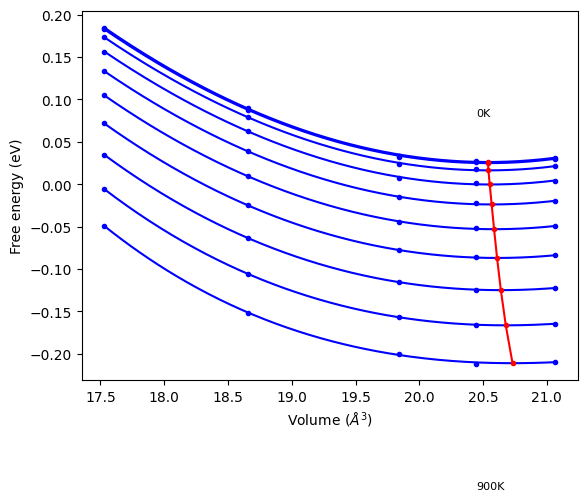

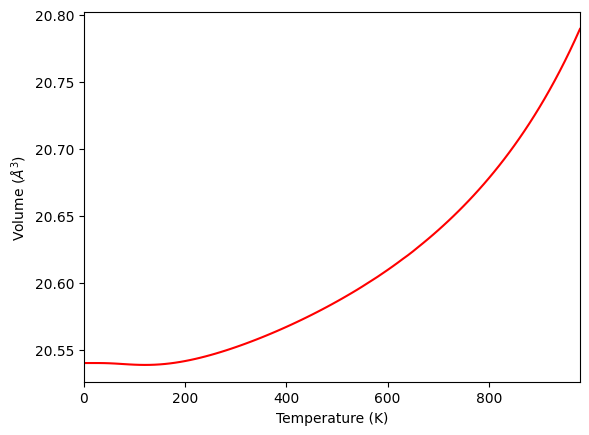

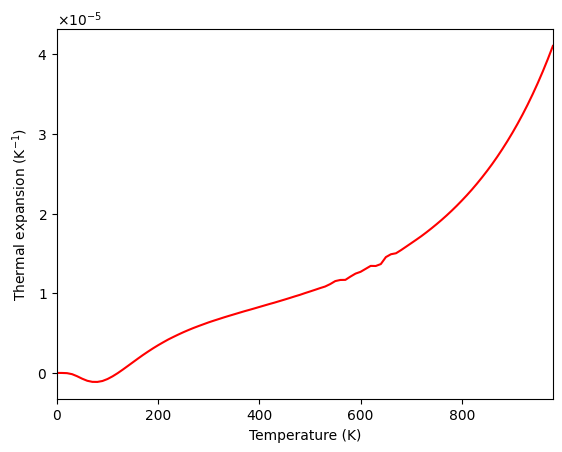

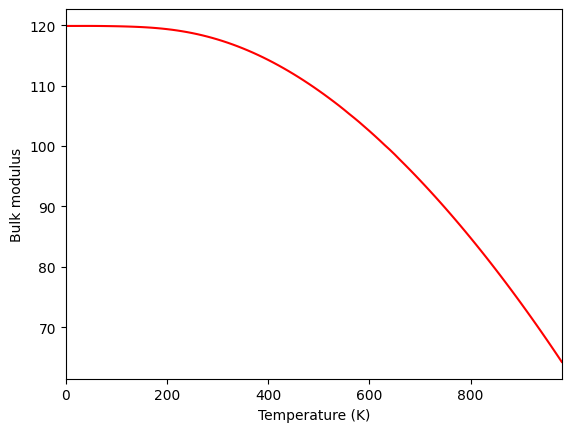

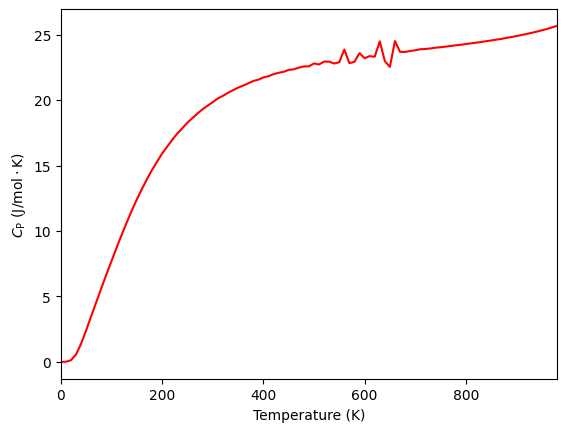

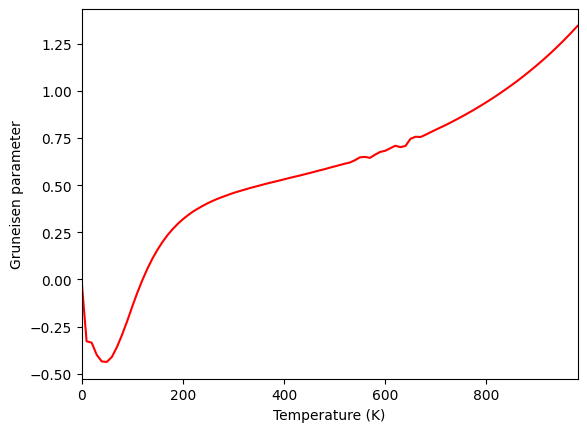

In [5]:
with mock_vasp(ref_paths=ref_paths) as mf:
    run_locally(
        flow,
        create_folders=True,
        ensure_success=True,
        raise_immediately=True,
        store=job_store,
    )

## Let's retrieve the data and analyze it

In [6]:
job_store.connect()

result = job_store.query_one(
    {"name": "analyze_free_energy"},
    properties=[
        "output.helmholtz_volume",
        "output.temperatures",
        "output.volumes",
    ],
    load=True,
    sort={"completed_at": -1},  # to get the latest computation
)

You can then plot some of the output free energy volume curves

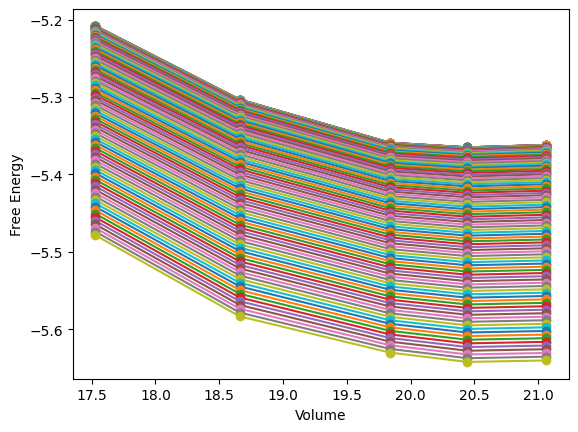

In [7]:
import matplotlib.pyplot as plt

for temp, energy_list in zip(
    result["output"]["temperatures"],
    result["output"]["helmholtz_volume"],
    strict=False,
):
    # Create the plot
    plt.plot(
        result["output"]["volumes"],
        energy_list,
        marker="o",
        label=temp,
    )
    # Add labels and title
plt.xlabel("Volume")
plt.ylabel("Free Energy")

# Show the plot
plt.show()